# Домашнее задание 2

В этом домашнем задании мы поупражняемся с ETS-моделью и STL-разложением. Сначала коротко про данные.

Представьте себе стандартный банкомат, который работает только на выдачу. Его нужно периодически пополнять наличностью, чтобы он функционировал непрерывно. Однако выезд инкассаторов является делом хлопотным и недешёвым, так что хотелось бы не гонять их лишний раз заполнять наполовину полный банкомат. Хотелось бы научиться предсказывать спрос людей на наличность в банкомате, чтобы можно было предсказывать время, когда количество денег в банкомате снизится до минимально допустимой величины. Этим мы и займёмся. Для простоты возьмём один конкретный банкомат. Нам доступны объёмы выдачи в банкомате по дням.

In [355]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.tsa.stattools import acf
from scipy.stats import chi2
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.ets import AutoETS

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)


##### 1) Загрузка данных и визуальный анализ (1 балл)

Важно! sktime довольно капризен в плане форматов даты-времени. Для работы некоторых функций может требоваться PeriodIndex или DateTimeIndex. Часто самые непонятные ошибки происходят из-за этого. К сожалению, на текущий момент это данность, но мы в вас верим.

Загрузите данные из файла atm.csv. Изобразите временной ряд, его автокорреляции (можно ещё автокорреляции первых разностей для большей ясности).  Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Опишите, как сделанные вами наблюдения помогут построить модель.

In [357]:
data = pd.read_csv("https://raw.githubusercontent.com/Pyatachokk/hse_ts_course/master/2024-spring/homeworks/hw2/atm.csv").rename(columns={'Unnamed: 0': 'date'})#.set_index('date')
data.date = pd.to_datetime(data.date)
data  = data.set_index('date')
data.head()

,target
date,
2015-01-01,213400.0
2015-01-02,94500.0
2015-01-03,63900.0
2015-01-04,134900.0
2015-01-05,99800.0


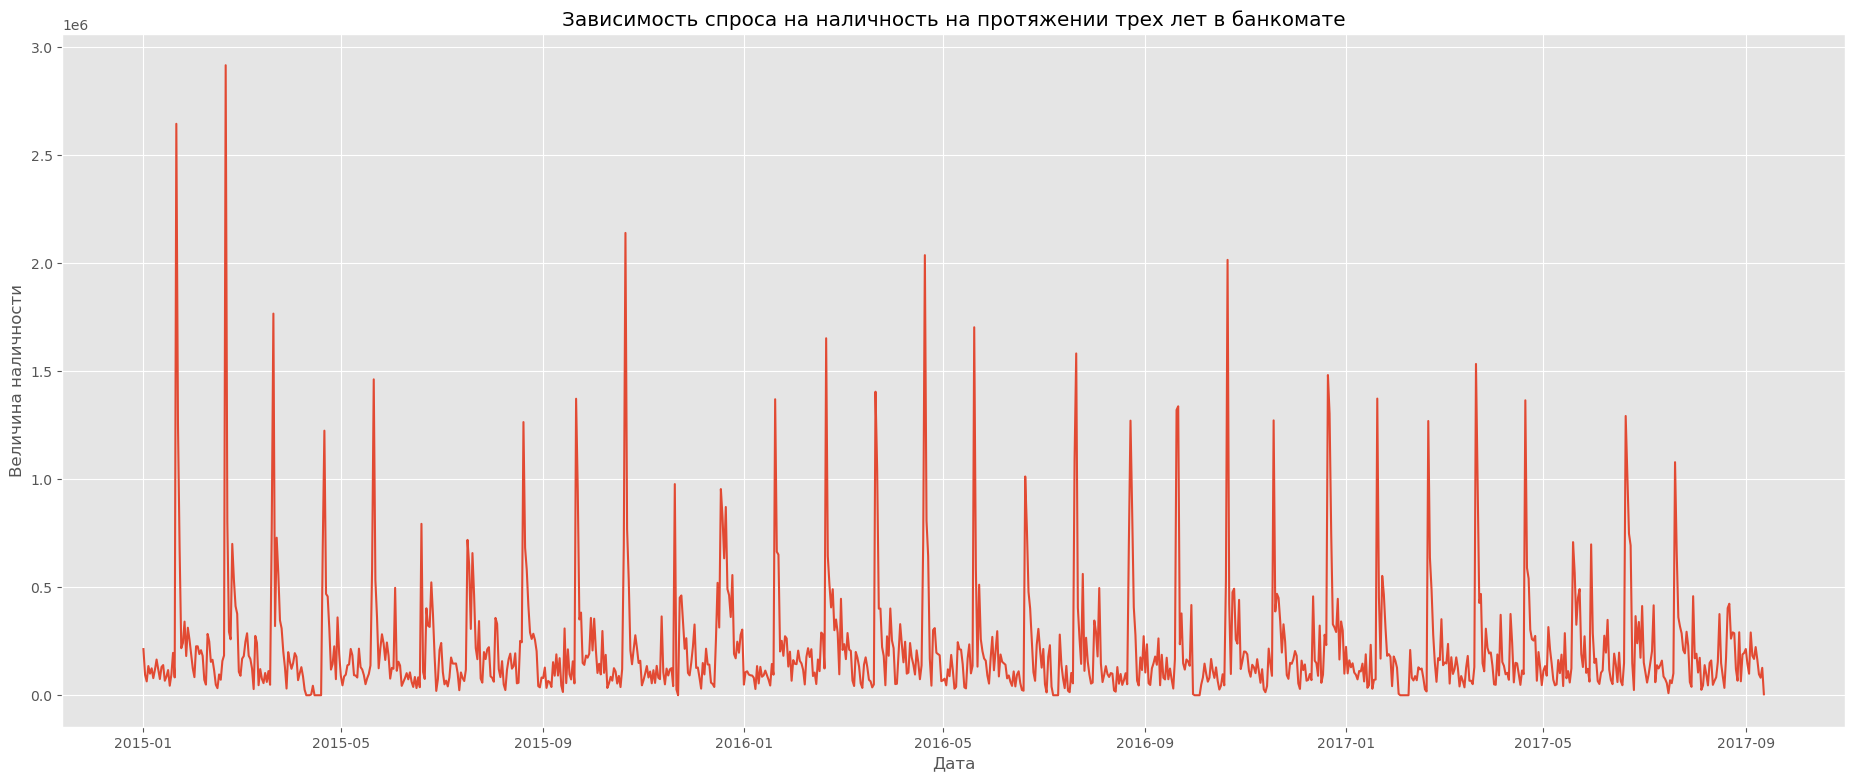

In [369]:
plt.plot(data.target)
plt.title('Зависимость спроса на наличность на протяжении трех лет в банкомате')
plt.xlabel('Дата')
plt.ylabel('Величина наличности');

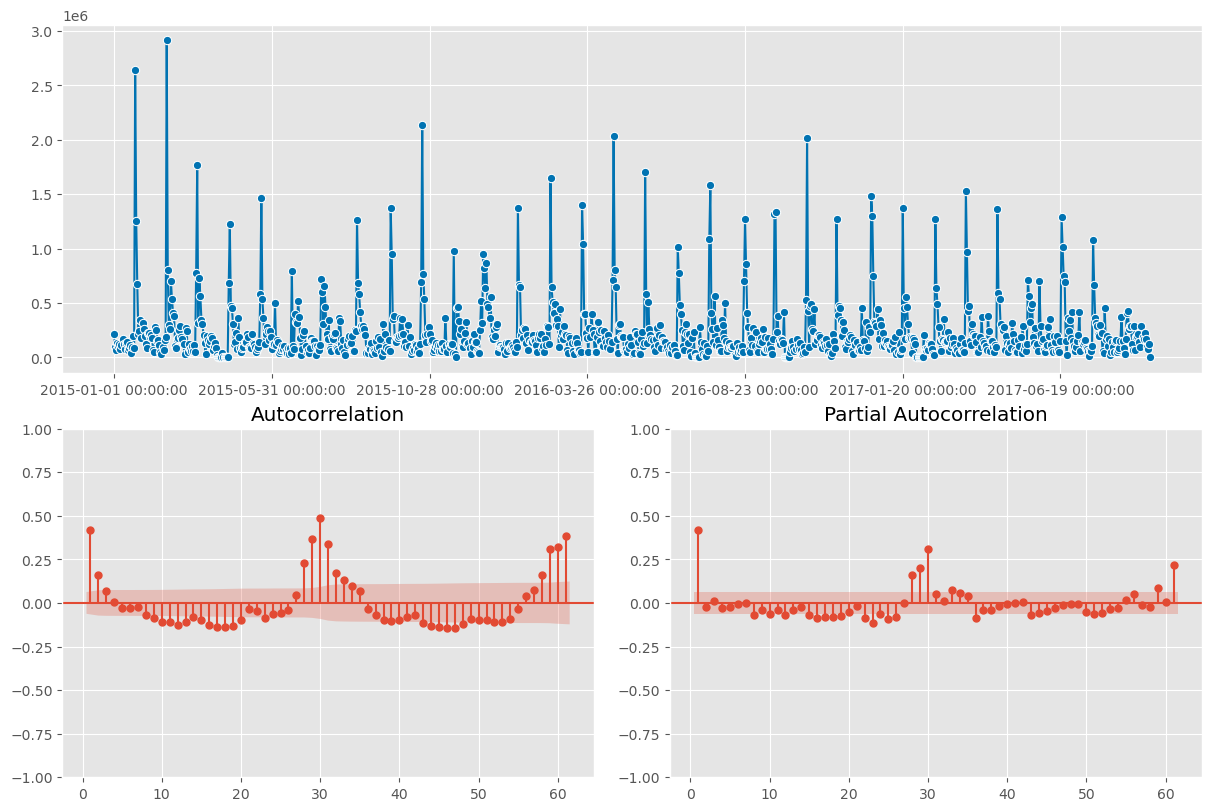

In [366]:
plot_correlations(data, lags = 61, zero_lag=False);

<Figure size 1200x600 with 0 Axes>

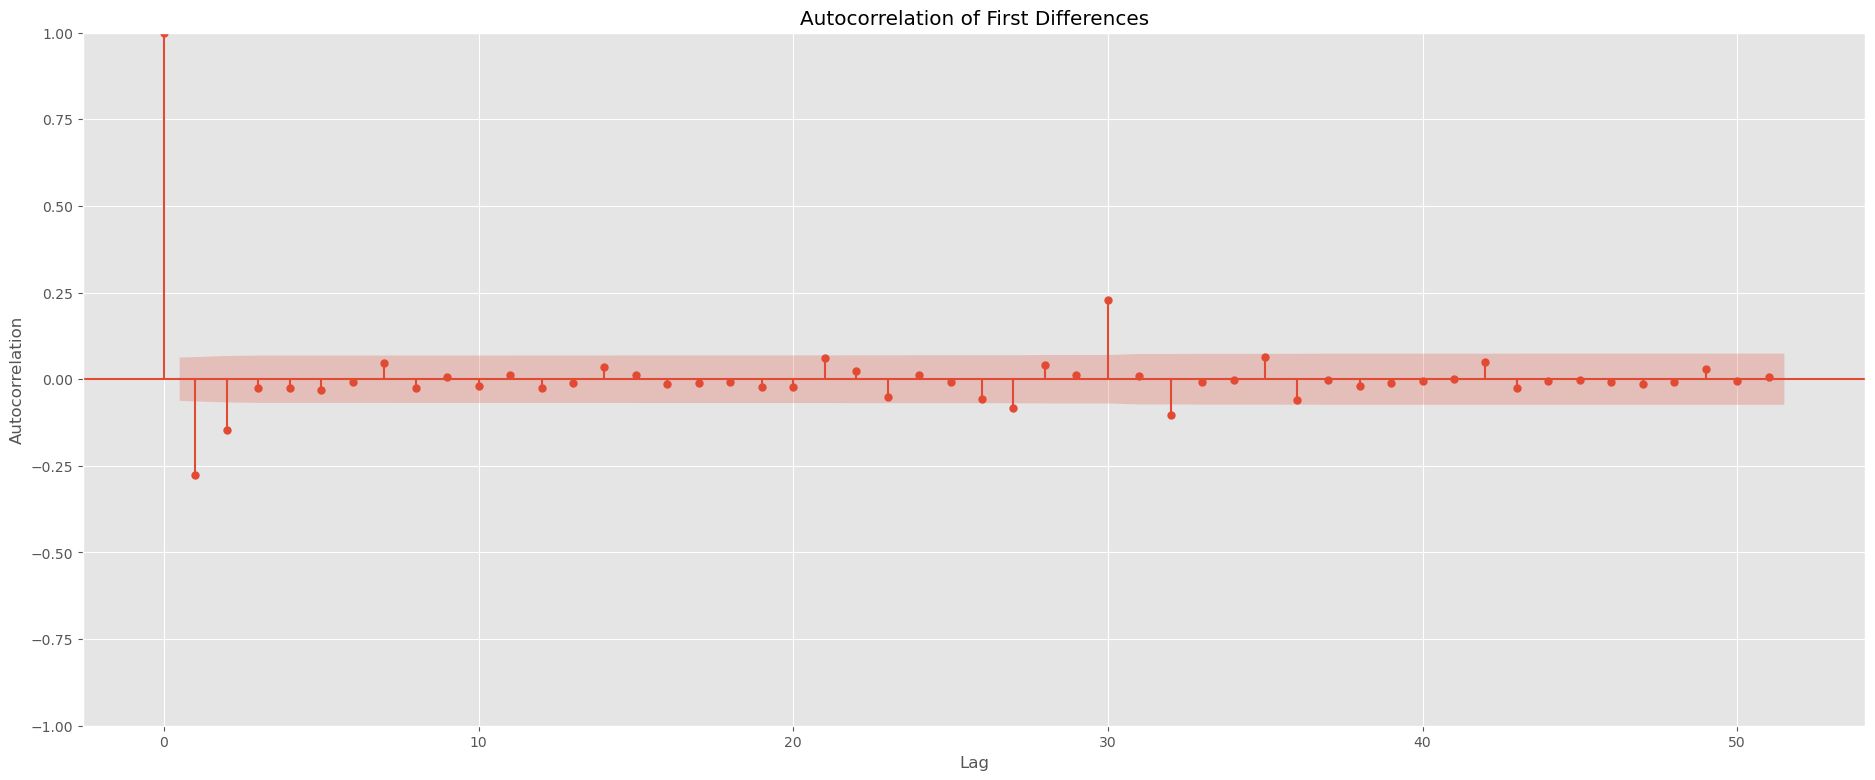

In [361]:
from statsmodels.graphics.tsaplots import plot_acf
diff = data['target'].diff()
plt.figure(figsize=(12, 6))
plot_acf(diff.dropna(), lags=51)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of First Differences')
plt.show();

На графике автокорреляций первых разностей значительные корреляции наблюдаются на первом и еще нескольких первых лагах, это может указывать на нестационарность ряда. Тренд не вижу. Точно есть месячная сезонность (на обоих графиках автокорреляции видно, что 30-лаг сильно значим, а также на первом графике выделяются еще и несколько лагов, предшествующие тому лагу, который кратен 30. Также стоит заметить, что значимыми являются лаги, которые находятся в промежутке двухнедельном (причем корреляция отрицательная и значимая на протяжении нескольких дней). В модель данные наблюдения пойдут в качестве фичей (я добавлю несколько лагов), а также это значит, что важные календарные фичи. Кажется, что цикличность присутвует - всегда после выделяющихся пиков (то есть дней, когда спрос был большой) наблюдается сильный спад, так на протяжении трех лет стабильно присутствуют циклические волны.



##### 2) Предобработка данных (0.5 балла)

Разбейте данные на трейн и тест. Размер теста: последние 50 дней.

Как легко заметить, данные неотрицательны. Но на случай использования мультипликативных моделей рекомендуется децентировать трейн в положительную полуось. Дополнительно можете произвести на трейне обратимые преобразования, которые сочтёте необходимыми (Box-Cox, детрендирование и т.п.).

In [370]:
y_train, y_test = temporal_train_test_split(data, test_size=50)

In [371]:
y_train = y_train + 1 #децентрировали в положительную полуось
y_test = y_test + 1

### Блок 1. STL/MSTL


Здесь и далее будем работать только с трейном. В данном разделе мы попробуем декомпозировать ряд с помощью STL или MSTL. В этом случае наш ряд можно представить в следующем виде:

$$y^{train}_t = t_t + s_t + e_t$$

 $t_t$ - компонента трейна

 $s_t$ - компонента сезонности, в случае MSTL будет несколько компонент сезонности
 
 $e_t$ - компонента остатков


Для каждой компоненты мы будем оценивать отдельную многошаговую модель. Компоненты тренда и сезонности обычно простые по своей структуре. Для них мы будем использовать какие-нибудь тривиальные модели. Компонента остатков обычно самая сложная, так как включает в себя "всё остальное". Для неё мы будем строить модель с признаками аналогично ДЗ-1.

Каждую компоненту необходимо будет многошагово спрогнозировать на тестовый период. Так как STL-разложение аддитивно, прогнозы мы просто просуммируем.

$$\hat{y}^{test}_t = \hat{t}_t + \hat{s}_t + \hat{e}_t$$

Таким образом мы получим итоговый прогноз.


##### Разложение (0.3 балла)

Начнём с STL. Примените на трейне STL или MSTL-разложение (обоснуйте выбор). Обоснуйте период(ы), который вы берёте в качестве сезонного. Визуализируйте отдельные компоненты.

Пользуюсь mstl разложением, так как на графиках выше мы видели, что спрос коррелирует и с предыдущим днем, и с днем недельной давности (отрицательно) как минимум. Хотелось использовать больше, чем одну сезонность (а почему-то sktime не позволил мне использовать 24*30 еще, то есть месячный период - не поняла, в чем проблема была, но оно не выводилось).

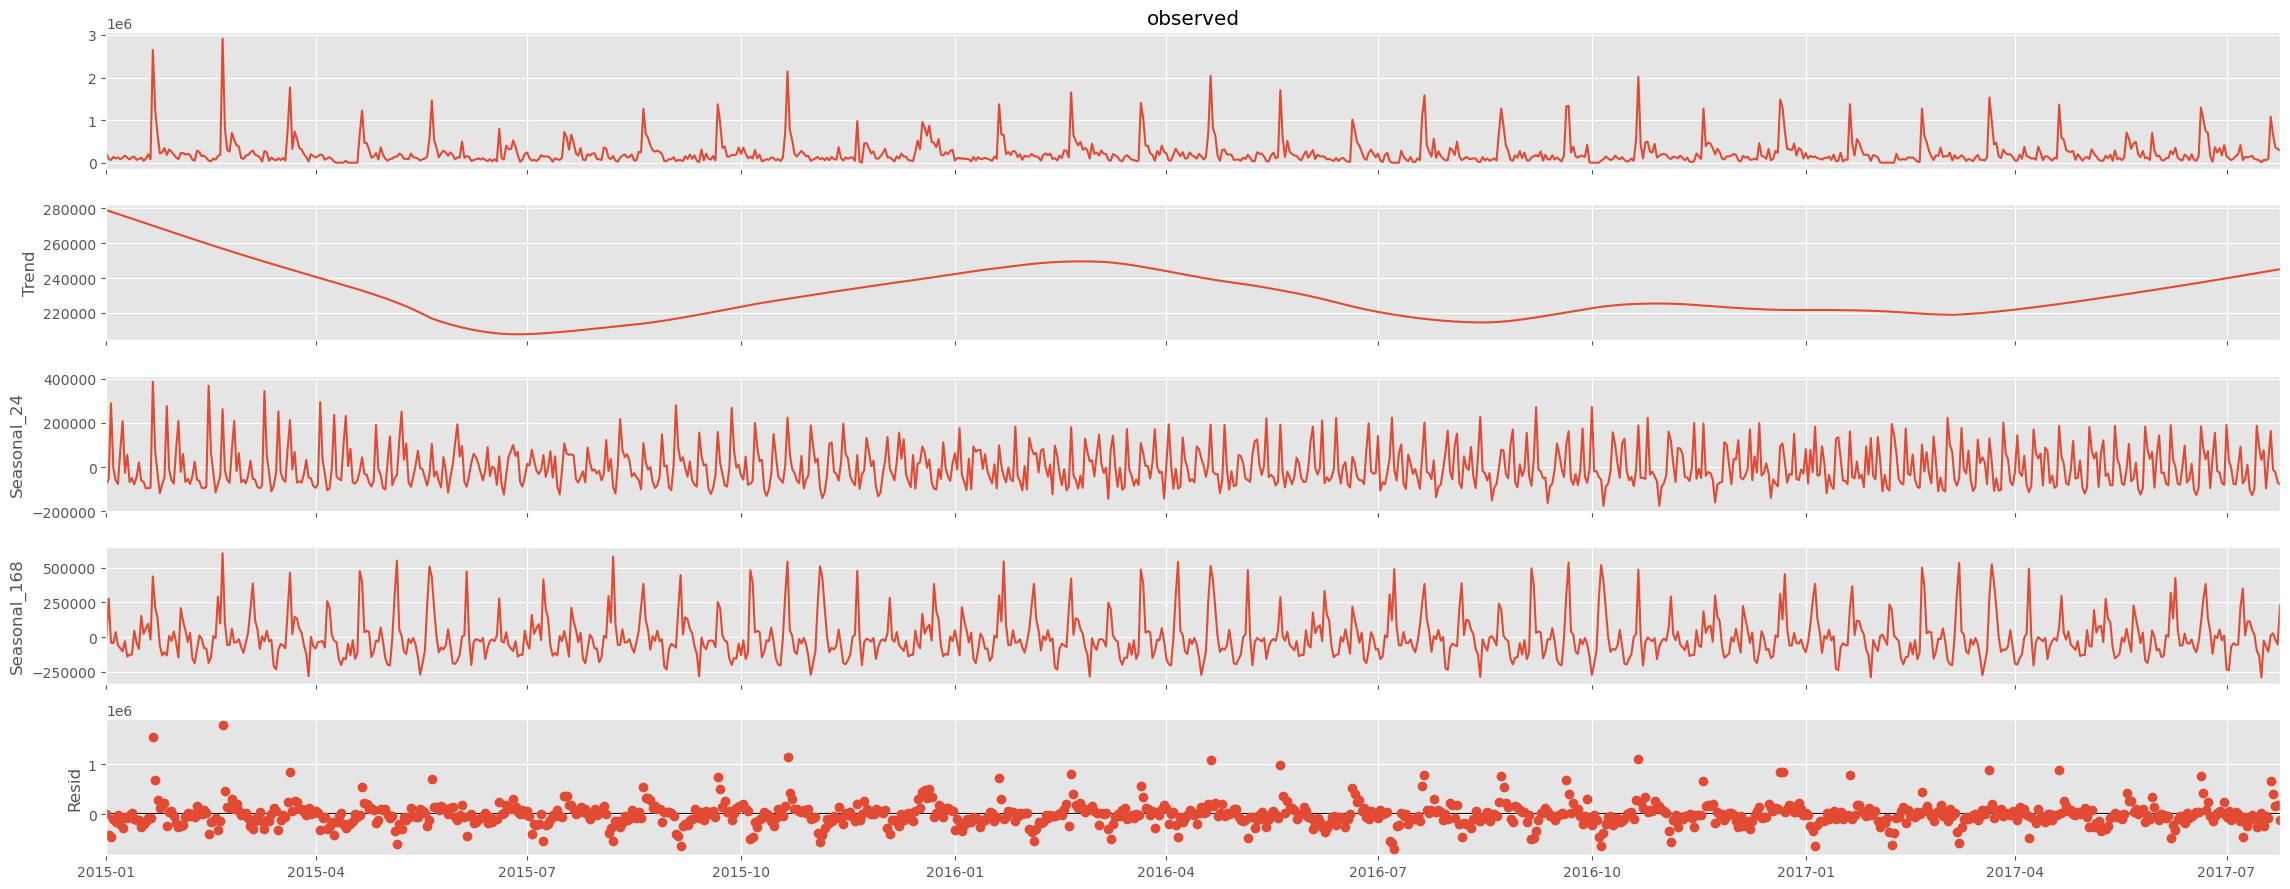

In [435]:
mstl = MSTL(y_train.target, periods=[24, 24*7], iterate=3, stl_kwargs={"seasonal_deg": 0, 
                                                                          "inner_iter": 2, 
                                                                          "outer_iter": 0})
res = mstl.fit() 
ax = res.plot()
plt.tight_layout()

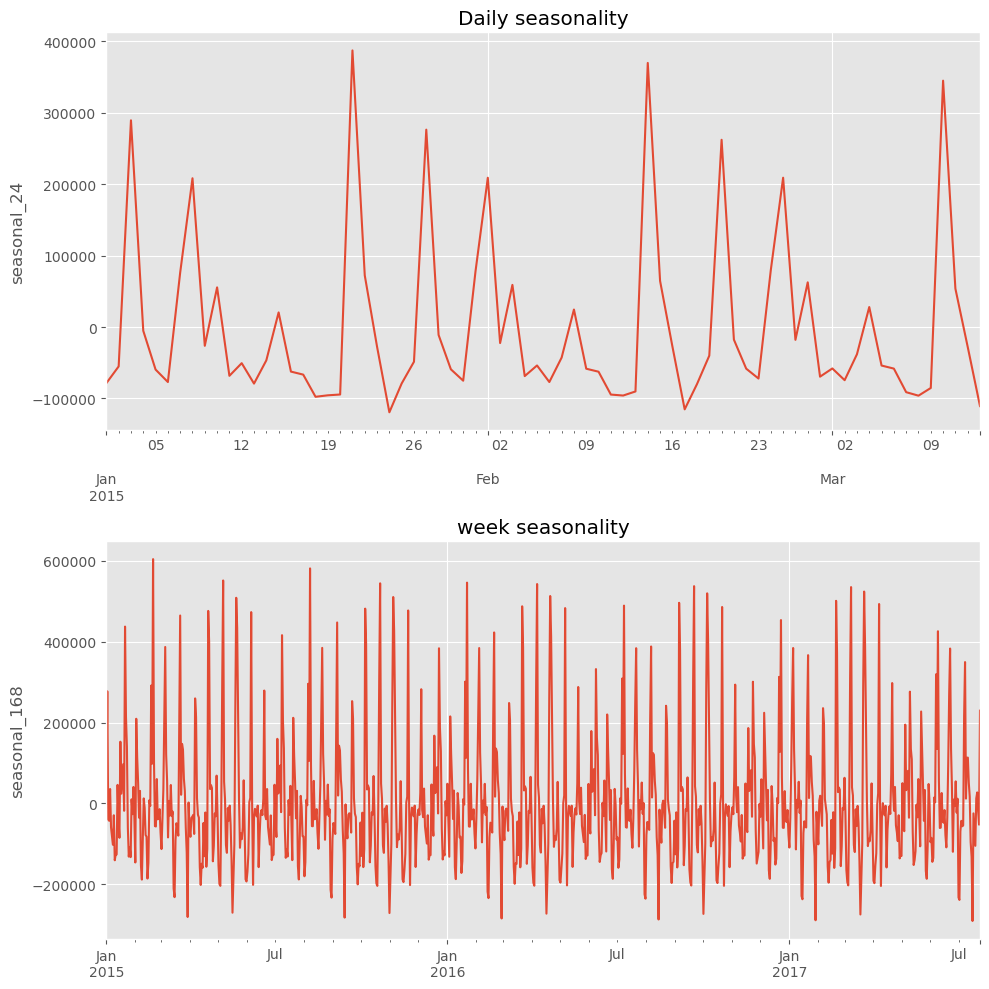

In [437]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
res.seasonal["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal["seasonal_168"].iloc[:24*14*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("week seasonality")

plt.tight_layout()

##### Прогнозирование тренда (0.3 балла)

Достаньте из оценённой модели компоненту тренда. Спрогнозируйте этот ряд на длину теста любой простой моделью в зависимости от вида ряда (Наивная, RandomWalk, любой алгоритм сглаживания, ...).

In [438]:
trend = res.trend
test_period_length = len(y_test.target)
naive_forecast = [trend[-1]] * test_period_length
naive_forecast[:3]

[245082.76841773326, 245082.76841773326, 245082.76841773326]

##### Прогнозирование сезонности (0.3 балла)

Достаньте из модели компоненту или компоненты сезонности. Аналогично спрогнозируйте любой простой моделью без фичей.

In [440]:
seas1 = res.seasonal["seasonal_24"]
seas2 = res.seasonal["seasonal_168"]
naive_seas_1 = seas1[-1]
naive_seas_2 = seas2[-1]

print("Прогноз для первой сезонной компоненты:", naive_seas_1)
print("Прогноз для второй сезонной компоненты:", naive_seas_2)

Прогноз для первой сезонной компоненты: -79046.5914465447
Прогноз для второй сезонной компоненты: 229371.21463111285


#### Прогнозирование остатков. 

Теперь возьмёмся за самую сложную часть, прогнозирование компоненты остатков. Достаньте из модели эту компоненту.


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='resid'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

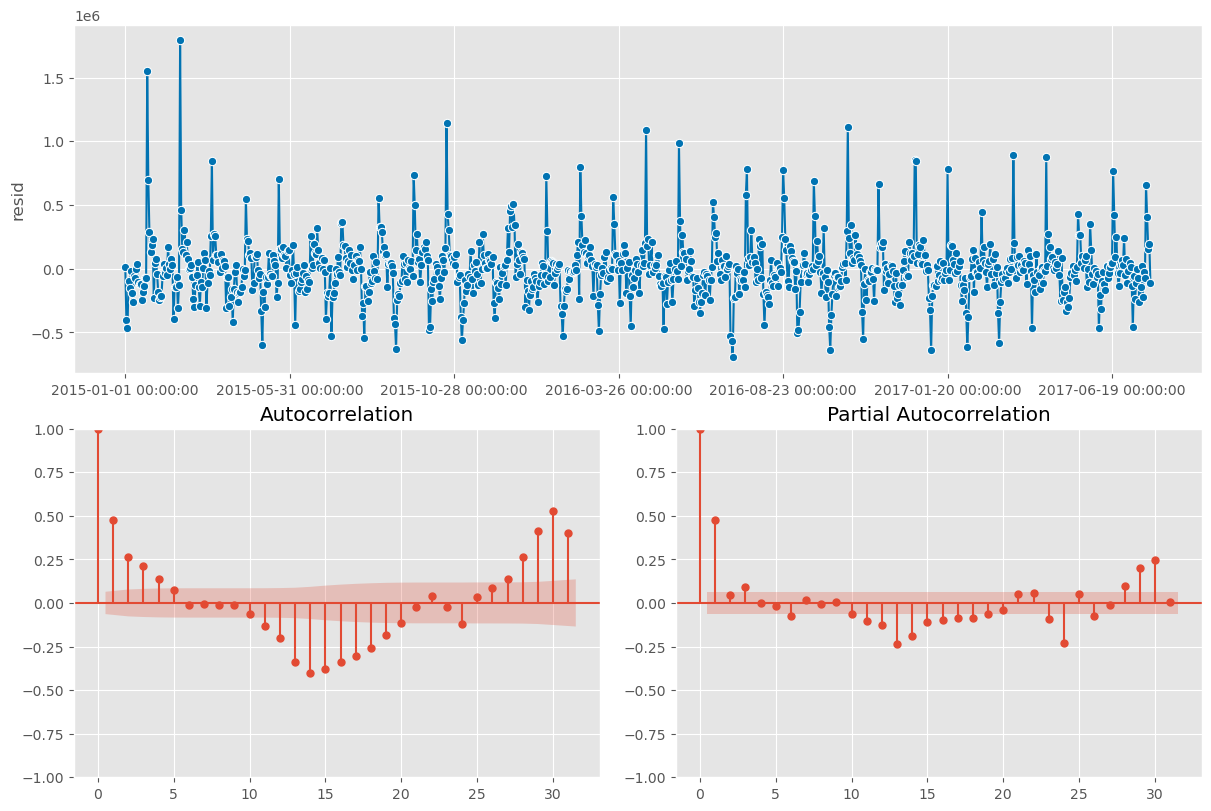

In [441]:
resid = res.resid
plot_correlations(res.resid, 31)


##### Подготовка данных (0.9 балла)

Многошаговый прогноз остатков потребует уже модели с фичами. По сути эта задача эквивалентна многошаговому прогнозированию из ДЗ-1. Стратегия многошагового прогнозирования и выбор модели также остаётся на ваше усмотрение. В текущем пункте вам необходимо подготовить фичи для модели. В этот раз вам не будет дано конкретных указаний по генерации переменных. Но будет выдана дополнительная информация о банкомате. Можете её использовать, можете нет, на ваше усмотрение. 

Расположение: ул Крымский Вал, 9стр45

Дополнительная информация: ГАУК культуры города Москвы ЦПКиО им. М.Горького

Широта: 55.73259

Долгота: 37.600891

Также в помощь прилагается файл с различными календарными фичами (events.csv), чтобы не повторять в этой домашке то же самое, что в прошлой. Можете использовать любые фичи из этого файла, но для засчитывания пункта необходимо придумать минимум три фичи (по 0.3 за каждую), не входящие в приложенный файл. Каждую используемую фичу (не важно, из файла или придуманную вами) необходимо кратко обосновать. Не забывайте учитывать потенциальные утечки. За их наличие балл также может быть снижен.

Результатом пункта должны быть вектор e_train и матрица e_X_train для модели остатков.

Я скачала исторические посуточные погодные данные - буду использовать данные по температуре и погодным условиям в целом (так как банкомат находится в парке горького от погодных условий ОЧЕНЬ сильно зависит количество людей, посетивших парк, а это напрямую влияет на величину спроса на наличность в этом банкомате). Также добавила лаги, о которых говорила выше, и выбрала несколько готовых фичей, к ним добавила квартальную фичу - чтобы модель и эту информацию имела, она может быть полезна из-за наличия сезонности. Данные по посещаемости пг или музеона я не нашла, и когда она были закрыты - тоже. 
Почему выбрала эти фичи из готового файла: в выходные, праздники, предвыходные и предпраздники люди больше гуляют, им нужна наличность, например, чтобы потратить деньги на территории парков. В праздники и предновогодние дни к тому же нужна наличность, чтобы купить подарки, также оставила дни недели, возможно модель найдет зависимости от дней недели, также рядом с пг находится университет мисис и станция метро (и может быть действительно потом людей разный в зависимости от дня недели).

In [442]:
calendar_full = pd.read_csv('https://raw.githubusercontent.com/Pyatachokk/hse_ts_course/master/2024-spring/homeworks/hw2/events.csv').rename(columns={'Unnamed: 0': 'date', 'фпрель': 'апрель'})
calendar_full['date'] = pd.to_datetime(calendar_full['date'])
calendar_full = calendar_full.set_index('date')
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2017-09-12')
calendar = calendar_full.loc[start_date:end_date]
cols=['выходной', 'праздник','предвыходной',
       'предпраздничный рабочий день', 'пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс', 
      '27-Дек', '28-Дек',
       '29-Дек', '30-Дек', '31-Дек']
calendar = calendar.loc[:, cols]


In [443]:
weather_df = pd.read_csv('weather_moscow.csv') #скачала данные посуточные с сайта c visual crossing weather data service
weather = weather_df[['datetime', 'temp', 'conditions']].rename(columns={'datetime': 'date'}) 
weather['date'] = pd.to_datetime(weather['date'])
weather=weather.set_index('date')
result = calendar.join(weather, on='date').join(y_train, on='date')
result['квартал']= result.index.quarter
result['y_L1'] = result['target'].shift(1) #я все еще не понимаю, считаются ли лаги таргета утечками (и какие примеры утечек кроме y(t)-y(t-1) могут быть
result['y_L2'] = result['target'].shift(2) #пользуюсь, тк в дз1 нужно было обязательно лагировать предыдущие значения таргета - и это считалось нормальным
# result['y_L28'] = result['target'].shift(28)
result['y_L29'] = result['target'].shift(3)
result['y_L30'] = result['target'].shift(30)
result=pd.get_dummies (result, columns=['conditions'], drop_first= True )
e_X_train= result.iloc[:-50].drop('target', axis=1)
e_X_test= result.iloc[-50:].drop('target', axis=1)
e_y_train= resid
e_X_test

,выходной,праздник,предвыходной,предпраздничный рабочий день,пн,вт,ср,чт,пт,сб,...,y_L30,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Overcast","conditions_Snow, Partially cloudy","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy"
date,,,,,,,,,,,,,,,,,,,,,
2017-07-25,0,0,0,0,0,1,0,0,0,0,...,24001.0,False,True,False,False,False,False,False,False,False
2017-07-26,0,0,0,0,0,0,1,0,0,0,...,366001.0,False,True,False,False,False,False,False,False,False
2017-07-27,0,0,0,0,0,0,0,1,0,0,...,240501.0,False,False,False,False,True,False,False,False,False
2017-07-28,0,0,0,0,0,0,0,0,1,0,...,339101.0,False,False,False,False,True,False,False,False,False
2017-07-29,1,0,0,0,0,0,0,0,0,1,...,173401.0,False,False,False,False,True,False,False,False,False
2017-07-30,1,0,0,0,0,0,0,0,0,0,...,412701.0,False,False,False,False,True,False,False,False,False
2017-07-31,0,0,0,0,1,0,0,0,0,0,...,151201.0,False,False,False,False,True,False,False,False,False
2017-08-01,0,0,0,0,0,1,0,0,0,0,...,105501.0,False,False,False,False,True,False,False,False,False
2017-08-02,0,0,0,0,0,0,1,0,0,0,...,58401.0,False,True,False,False,False,False,False,False,False


#### Кросс-валидация

Теперь займёмся подбором оптимальной модели остатков. Для этого используем кросс-валидацию.

##### Реализация метода (0.6 балла)

Реализуйте метод скользящего окна. Реализуйте класс, который будет по входным параметрам окна выдавать индексы всех фолдов. По поведению можно ориентироваться на знакомый вам k-fold. Хорошей практикой будет возвращать в методе split генератор, хотя это и не обязательно. На каждом фолде модель будет обучаться на трейне и делать многошаговый прогноз на тест. 

Позаботьтесь о том, чтобы ширина окна была соотнесена в логичной пропорции с горизонтом прогнозирования. Длина трейна 55 при горизонте 50 -- сомнительная практика.


In [444]:
class CustomCrossVal:
    def __init__(self, window_size: int, step: int):
        self.window_size = window_size
        self.step = step
        self.num_folds = None
        
    def split(self, y, X):
        self.num_folds = (len(X) - self.window_size) // self.step 

        for i in range(0, len(X) - self.window_size, self.step):
            start = i
            end = i + self.window_size
            yield y.iloc[start:end], X.iloc[start:end, :], y.iloc[end:end+self.step], X.iloc[end:end+self.step, :]

##### Отбор моделей (0.5 балла)

Выберите несколько моделей-кандидатов исходя из свойств ряда (обоснуйте) и отберите с помощью реализованной вами кросс-валидации наилучшую. Можно использовать разные модели либо разные наборы фичей. Метрика: MAE.

Я надеюсь, я правильно поняла условие, что можно либо кросс-валидировать разные модели (деревья, бустинг, линрег и тд), либо сразу выбрать модель (например, бустинг) и поподбирать гиперпараметры для него. Я решила выбрать второй вариант, ибо по-любому я бы использовала бустинг (и матвей тоже об этом писал в чате) и тогда надо подобрать гиперпараметры (в ets также). 

Еще я сначала использовала комбинацию гридсерчсв из коробки и моего класса, а потом у меня возникли подозрения, что из коробки ничего использовать нельзя конкретно здесь, раз мы свой класс как бы пишем, поэтому все в великолепных циклах :) 

In [445]:
custom_cv = CustomCrossVal(window_size=50, step=25)

best_params = None
best_score = float('inf')

for learning_rate in [0.01, 0.05, 0.1 ]:
    for depth in [ 6, 8]:
        for l2_leaf_reg in [1, 3]:
            total_mae = 0
            for y_train_batch, X_train_batch, y_test_batch, X_test_batch in custom_cv.split(e_y_train, e_X_train):
                model = CatBoostRegressor(learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, verbose=False)
                model.fit(X_train_batch, y_train_batch)
                predictions = model.predict(X_test_batch)
                mae = mean_absolute_error(y_test_batch, predictions)
                total_mae += mae

            avg_mae = total_mae / custom_cv.num_folds
            if avg_mae < best_score:
                best_score = avg_mae
                best_params = {'learning_rate': learning_rate, 'depth': depth, 'l2_leaf_reg': l2_leaf_reg}

print("Лучшие параметры:", best_params)
print("Лучшая оценка:", best_score)


Лучшие параметры: {'learning_rate': 0.01, 'depth': 8, 'l2_leaf_reg': 3}
Лучшая оценка: 151160.46402624593


##### Прогноз моделей (0.5 балла)

Обучите наилучшую модель остатков на всём трейне и постройте прогноз на тестовый период, используя выбранную вами многошаговую стратегию.

In [446]:
e_X_test_copy = e_X_test.copy()
model = CatBoostRegressor(learning_rate=0.01, depth=8, l2_leaf_reg=3, verbose= False)
model.fit(e_X_train, e_y_train)
predictions = []
#использую рекурсивную стратегию тк данных не много
for i in range(len(e_X_test_copy)):
    prediction = model.predict(e_X_test_copy.iloc[[i]])
    predictions.append(prediction[0])
    e_X_test_copy.iloc[i, -1] = prediction[0]

##### Результаты и визуализация (0.6 балла)

Соберите в сумму прогнозы всех компонент STL-разложения на тесте. Не забудьте на сумму прогнозов компонент применить преобразования, обратные тем, которые были сделаны на трейне.  Визуализируйте прогноз и тестовые данные. Подсчитайте MAE прогноза.

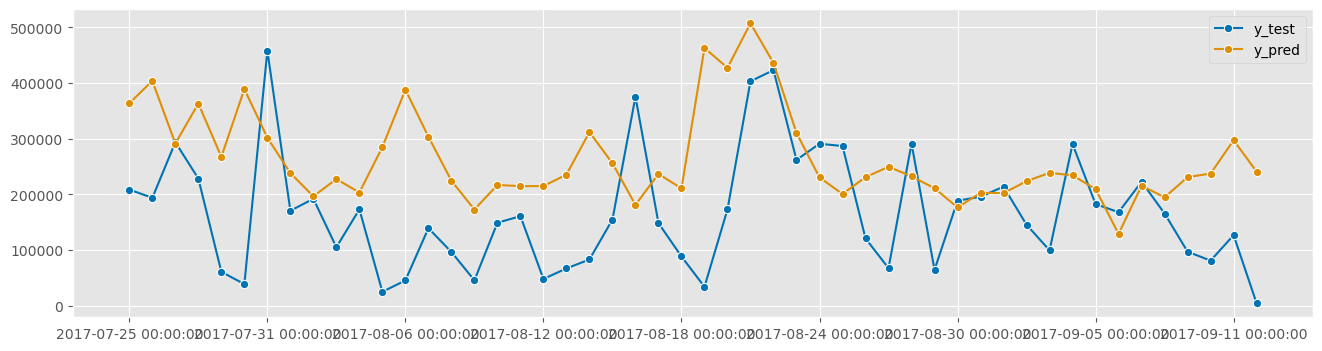

In [447]:
res_test_mstl = naive_seas_1 + naive_seas_2 + naive_forecast + predictions
res_test_series_mstl = pd.Series(res_test_mstl, index=y_test.index)
plot_series(y_test, res_test_series_mstl, labels=["y_test", "y_pred"]);

In [448]:
mean_absolute_error(y_test, res_test_mstl)

125079.98863202639

##### Бэктестинг (0.75 балла)

Попробуем протестировать in-sample итоговую модель, которая получилась. Для этого нам необходимо получить остатки суммарной модели на трейне. Для этого нам необходимо вернуться к моделям отдельных компонент и построить одношаговые прогнозы на всём участке train.

$$e^{clean}_t = y^{train}_t - (\hat{t}^{train}_t + \hat{s}^{train}_t + \hat{e}^{train}_t)$$

Нарисуйте графики автокорреляций этих остатков. Есть ли в каких-то интересных датах значимые пики? Как думаете, с чем эти ошибки модели связаны? (0.5 балла)

Проведите тест Ljung-Box. Протестируйте остатки на наличие серийных автокорреляций при нескольких m. Проинтерпретируйте результаты теста $\alpha = 0.05$. (0.25 балла)

Если нулевая гипотеза отвергается, можете попытаться улучшить модель и поискать фичи по графикам автокорреляций, но это опционально. В ряде ситуаций становится сложно построить модель, в которой гипотеза не отвергается, поэтому иногда на наличие автокорреляций закрывают глаза.

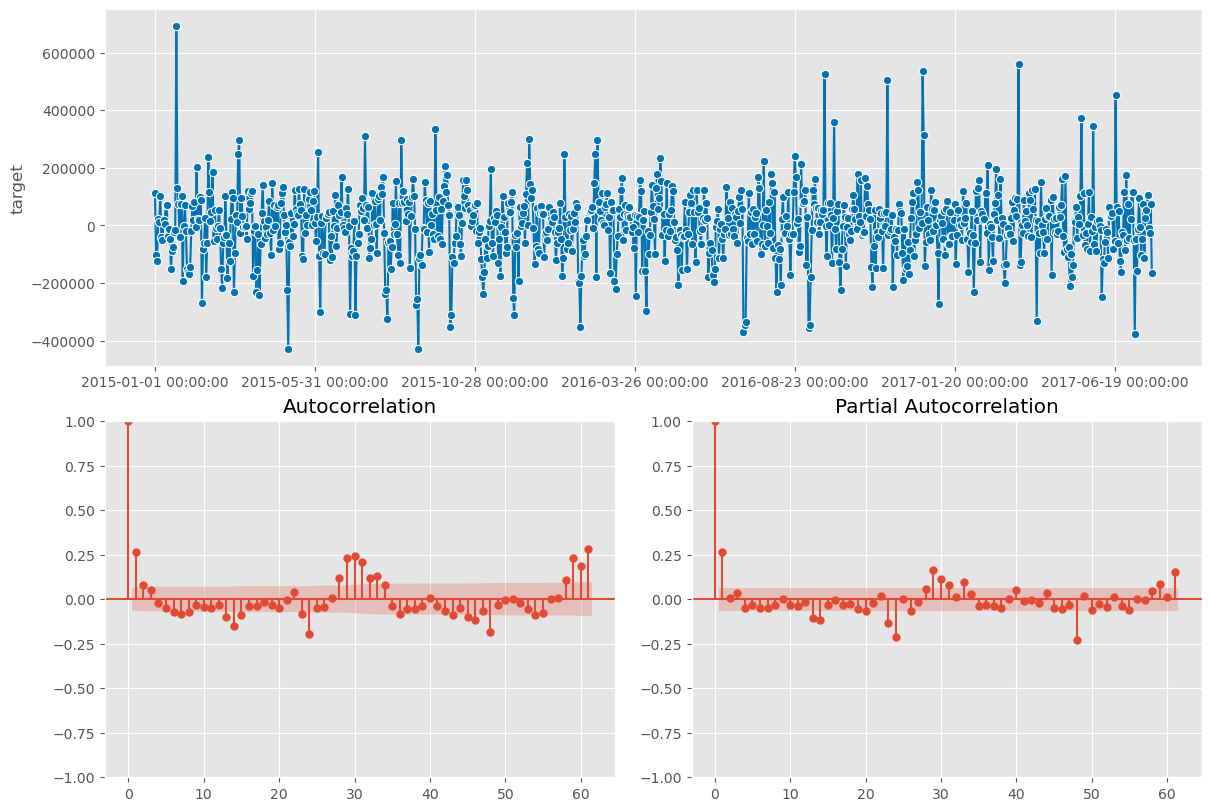

In [452]:
e_X_train_copy = e_X_train.copy()
err_train_pred = model.predict(e_X_train_copy)
res_train = np.array(res.seasonal["seasonal_24"]) + np.array(res.seasonal["seasonal_168"]) +np.array(res.trend) + np.array(err_train_pred)
e_cleaned = y_train.target - (res_train)
plot_correlations(e_cleaned, 61);

Возможно, мало данных или фичи не очень хорошо подобраны, потому что у нас по факту только лаги, календарь и погода и все. Мы не обрабатывали выбросы, наверное, это тоже сказалось (мы не обрабатывали события, которые выходили за рамки списка праздников или каких-то других примечательных дней именно государственных). И наверное тренд и сезонность надо не константно прогнозировать, а более по-умному делать, а не как у меня)

In [450]:
n_lags = 30
n_obs = len(e_cleaned)
denominators = n_obs - np.arange(1, n_lags+1)

autocorrelations = acf(e_cleaned, nlags=n_lags)[1:]
ljung_box_statistics = n_obs * (n_obs +2) * ((autocorrelations**2 / denominators)).sum()
ljung_box_statistics
ljung_box_pval = 1 - chi2.cdf(ljung_box_statistics, df=n_lags)

f"Ljung-Box test. Statistics: {ljung_box_statistics}, p-value: {ljung_box_pval}" #p-val < alpha => отвергаем H0 ->автокорреляция есть
#я правда пыталась попробовать другие комбинации фичей, но все равно отвергается

'Ljung-Box test. Statistics: 305.9124643053553, p-value: 0.0'

Исходя из данного значения p-значения (меньше 0.05), мы можем отклонить нулевую гипотезу о том, что нет серийной автокорреляции в остатках. Это говорит о том, что остатки в модели скорее всего не случайны и могут содержать некоторую систематическую зависимость.

### Блок 2. ETS-модель

Теперь повторим то же самое, только моделировать тренд и сезонность будем ETS-моделью, а на остатки ETS-модели навешивать вторую модель.

$$y^{train}_t = y^{ETS}_t + e^{ETS}_t$$


##### Визуальный анализ (1 балл)

Вернитесь к y_train. Взгляните на ряд и опишите, какие из вариантов ETS-модели подошли бы под наши данные. Сформируйте сетку параметров для моделей-кандидатов. Кратко поясните каждую опцию, которую вы включаете в сетку, основываясь на визуальном анализе.

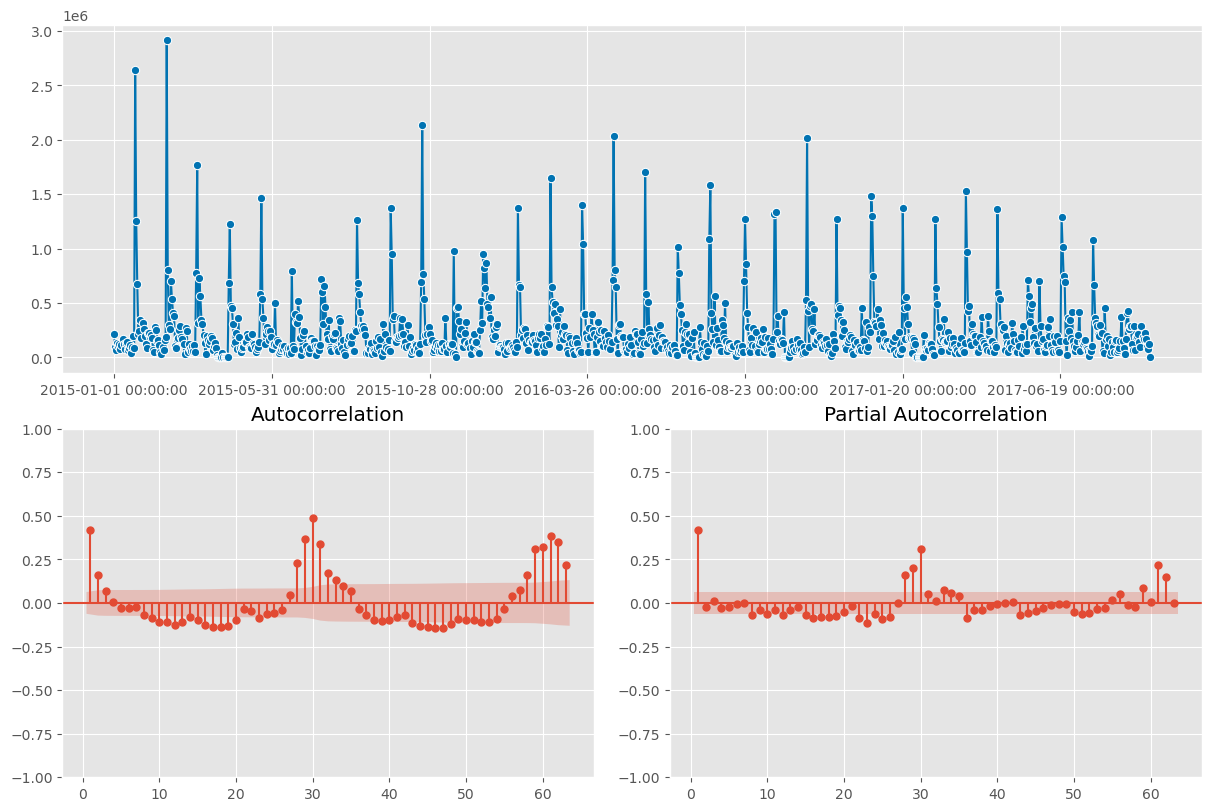

In [453]:
plot_correlations(data, lags = 63, zero_lag=False);

In [454]:
y_train, y_test = temporal_train_test_split(data, test_size=50)
fh = ForecastingHorizon(list(range(1, len(y_test)+1)))
y_test = y_test+1
y_train = y_train+1
forecaster = AutoETS(sp=7)
param_grid = { #в наших данных точно есть сезонность (ну и ошибки разумеется, явно не белый шум), а вот тренд как будто не наблюдается, поэтому включим опцию в сетку
    'error': [ 'add', 'mul'], #не уверена по графику какая может быть ошибка
    'trend': [None, 'add', 'mul'], 
    'seasonal':[ 'add', 'mul'], #сезон может быть мультипликативным судя по графику, надо проверить
}

##### Кросс-валидация (0.3 балла)

С помощью кросс-валидации выберите наилучшую по MAE ETS-модель. Обучите её на всём трейне и спрогнозируйте на тест. 

In [455]:
cv = SlidingWindowSplitter(
    window_length=50,
    step_length=25,
    fh=fh)
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    scoring=mean_absolute_error,
    verbose=1,
    n_jobs=-1)
gscv.fit(y_train);

Fitting 34 folds for each of 12 candidates, totalling 408 fits


In [456]:
cv_results = gscv.cv_results_
results_df = pd.DataFrame(cv_results)
params_df = pd.json_normalize(results_df['params'])
results_df_expanded = pd.concat([results_df.drop(columns=['params']), params_df], axis=1)

results_df_expanded.columns = [
    "Mean Test MAE",
    "Mean Fit Time",
    "Mean Prediction Time",
    "Rank",
    "Error",
    "Seasonal",
    "Trend"
]
results_df_expanded = results_df_expanded.sort_values(by='Mean Test MAE', ascending=True)
results_df_expanded

,Mean Test MAE,Mean Fit Time,Mean Prediction Time,Rank,Error,Seasonal,Trend
0,2.058027e+05,0.053161,0.020150,1.0,add,add,None
3,2.062096e+05,0.118084,0.021641,2.0,add,mul,None
6,2.455745e+05,0.092742,0.021098,3.0,mul,add,None
1,4.718833e+05,0.073716,0.023949,4.0,add,add,add
4,7.427535e+05,0.164047,0.021410,5.0,add,mul,add
7,1.812492e+06,0.115068,0.018030,6.0,mul,add,add
5,2.914244e+08,0.212595,0.022043,7.0,add,mul,mul
10,6.179561e+11,0.225366,0.014778,8.0,mul,mul,add
2,2.056526e+14,0.141164,0.019080,9.0,add,add,mul
9,1.524871e+16,0.201256,0.016384,10.0,mul,mul,None


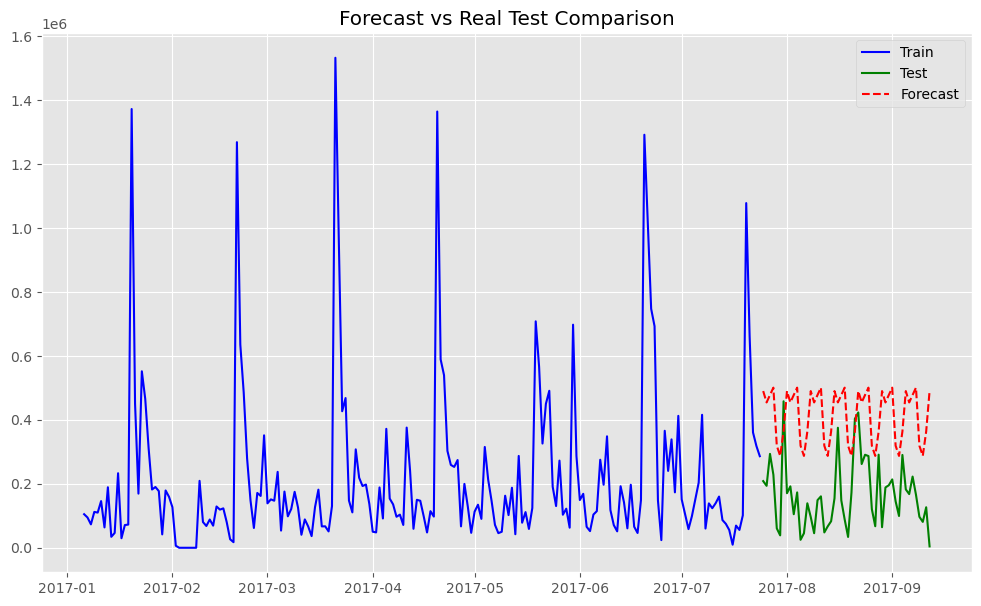

In [460]:
best_forecaster = gscv.best_forecaster_
best_forecaster.fit(y_train)

forecast = best_forecaster.predict(fh)
y_train_last = y_train.iloc[-200:]
plt.figure(figsize=(12, 7))
plt.plot(y_train_last.index, y_train_last, label='Train', color='blue')
plt.plot(y_test.index, y_test, label='Test', color='green')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--', color='red')
plt.legend()
plt.title('Forecast vs Real Test Comparison');

##### Подготовка данных (0.1 балла)

Достаньте остатки ETS-модели на трейне.
            $$e_{ETS} = y_{train} - \hat{y}_{train}$$

Это можно сделать с помощью метода predict_residuals. Построим на временном полученном временном ряде многошаговую модель. Можно использовать те же фичи, что и в разделе про STL, без дополнительных пояснений. Если вводите новые фичи, коротко поясните каждую. Результатом пункта должны быть вектор e_train и матрица e_X_train для модели остатков.

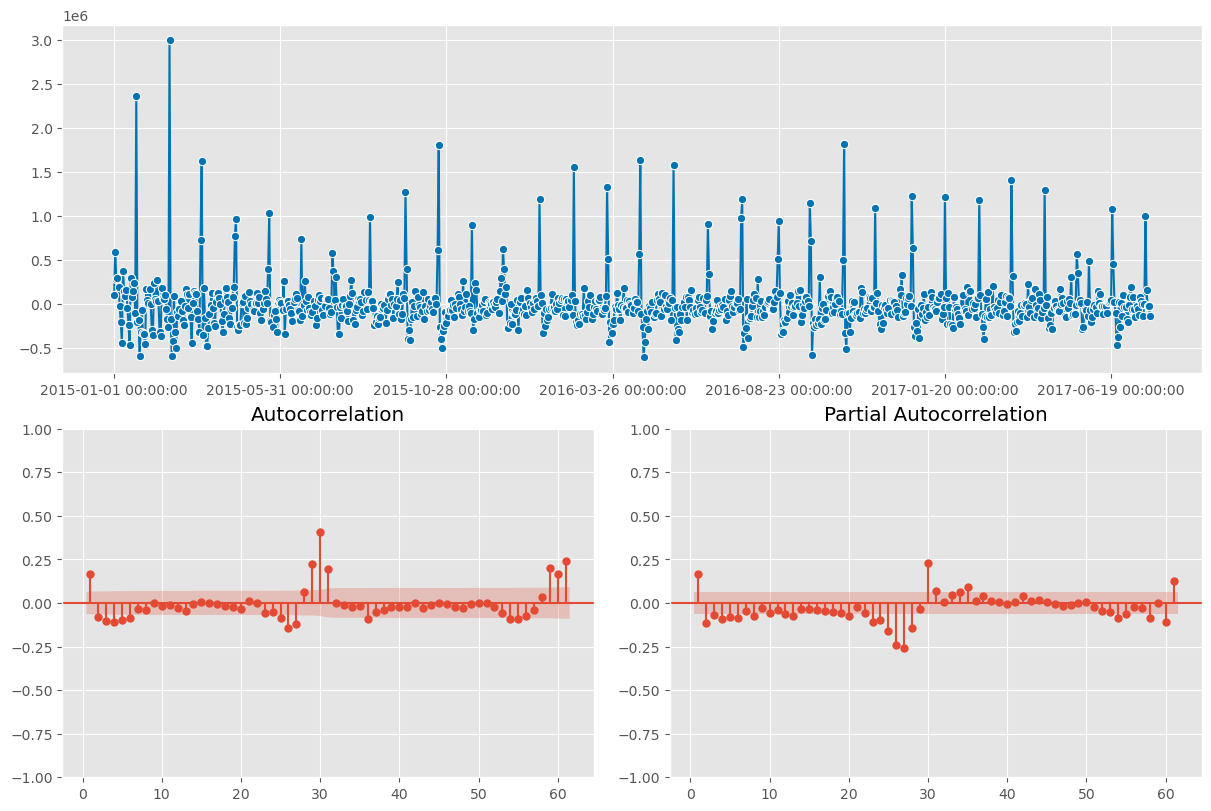

In [461]:
e_train =best_forecaster.predict_residuals(y_train)
plot_correlations(e_train, lags=61, zero_lag=False); #e_X_train без изменений из прошлой части

##### Отбор моделей и кросс-валидация (0.5 баллов)

Отберите несколько моделей-кандидатов для прогнозирования остатков и отберите на кросс-валидации наилучшую по MAE модель. Размер валидации на каждом фолде всё также равен длине тестовой выборки. Используйте реализованный ранее класс для кросс-валидации. 

In [462]:
custom_cv = CustomCrossVal(window_size=50, step=25)

best_params = None
best_score = float('inf')

for learning_rate in [0.01, 0.05, 0.1 ]:
    for depth in [6, 8]:
        for l2_leaf_reg in [1, 3, 5]:
            total_mae = 0
            for y_train_batch, X_train_batch, y_test_batch, X_test_batch in custom_cv.split(e_train, e_X_train):
                model = CatBoostRegressor(learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, verbose=False)
                model.fit(X_train_batch, y_train_batch)
                predictions = model.predict(X_test_batch)
                mae = mean_absolute_error(y_test_batch, predictions)
                total_mae += mae

            avg_mae = total_mae / custom_cv.num_folds
            if avg_mae < best_score:
                best_score = avg_mae
                best_params = {'learning_rate': learning_rate, 'depth': depth, 'l2_leaf_reg': l2_leaf_reg}

print("Лучшие параметры:", best_params)
print("Лучшая оценка:", best_score)

Лучшие параметры: {'learning_rate': 0.01, 'depth': 8, 'l2_leaf_reg': 3}
Лучшая оценка: 148380.04730028156


##### Прогноз остатков ETS (0.5 баллов)
Обучите наилучшую модель на всём наборе остатков трейна. Постройте прогноз на тест с помощью любой многошаговой стратегии.

Суммируйте прогнозы двух компонент в итоговый прогноз. Не забудьте в конце наложить обратные преобразования ряда, если вы их делали в самом начале.

$$\hat{y}^{test}_t = \hat{y}^{ETS}_t + \hat{e}^{ETS}_t$$

Подсчитайте MAE.


In [463]:
e_X_test_copy = e_X_test.copy()
model = CatBoostRegressor(learning_rate=0.05, depth=8, l2_leaf_reg=1, verbose= False)
model.fit(e_X_train, e_y_train)
predictions = []

for i in range(len(e_X_test_copy)):
    prediction = model.predict(e_X_test_copy.iloc[[i]])
    predictions.append(prediction[0])
    e_X_test_copy.iloc[i, -1] = prediction[0]


161321.62968802924

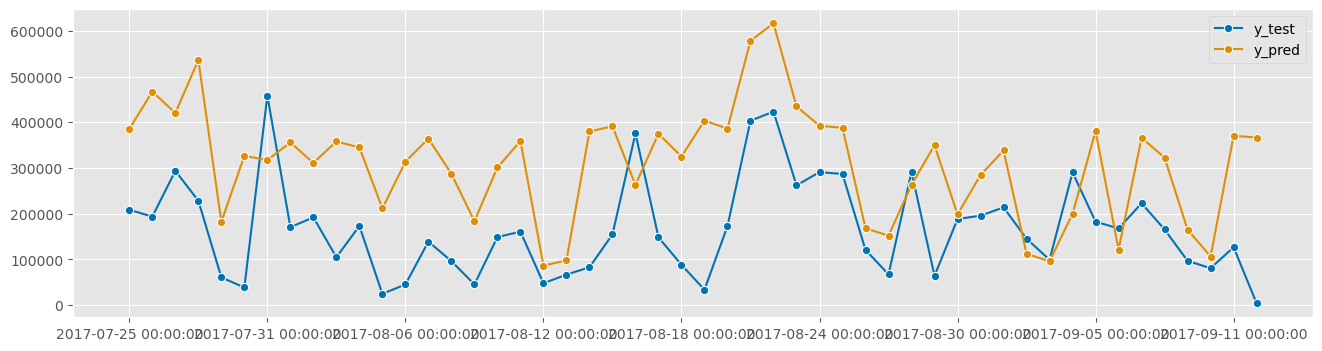

In [465]:
res_test_ets =forecast.target + predictions
res_test_series_ets = pd.Series(res_test_ets, index=y_test.index)
plot_series(y_test, res_test_series_ets, labels=["y_test", "y_pred"])
mean_absolute_error(res_test_series_ets, y_test)


##### Бэктестинг (0.5 балла)

Найдите остатки одношаговых моделей на тренировочной выборке.

$$e^{cleaned}_t = y^{train}_t - (\hat{y}^{ETS}_t + \hat{e}^{ETS}_t) $$

Так как получить одношаговые прогнозы $\hat{y}^{ETS}_t$ класс из Sktime почему-то не позволяет. Но мы помним, что 

 $$e_{ETS} = y^{train}_t - \hat{y}^{train}_t$$
 
Это выражение можно развернуть и получить искомое.

$$\hat{y}^{ETS}_t = y^{train}_t - e_{ETS}$$

А $e_{ETS}$ мы уже получали с помощью predict_residuals

Таким образом вы получите финальные остатки вашей двухуровневой модели. Нарисуйте графики автокорреляций этих остатков, проинтерпретируйте. Протестируйте их на наличие серийных автокорреляций тестом Ljung-Box.

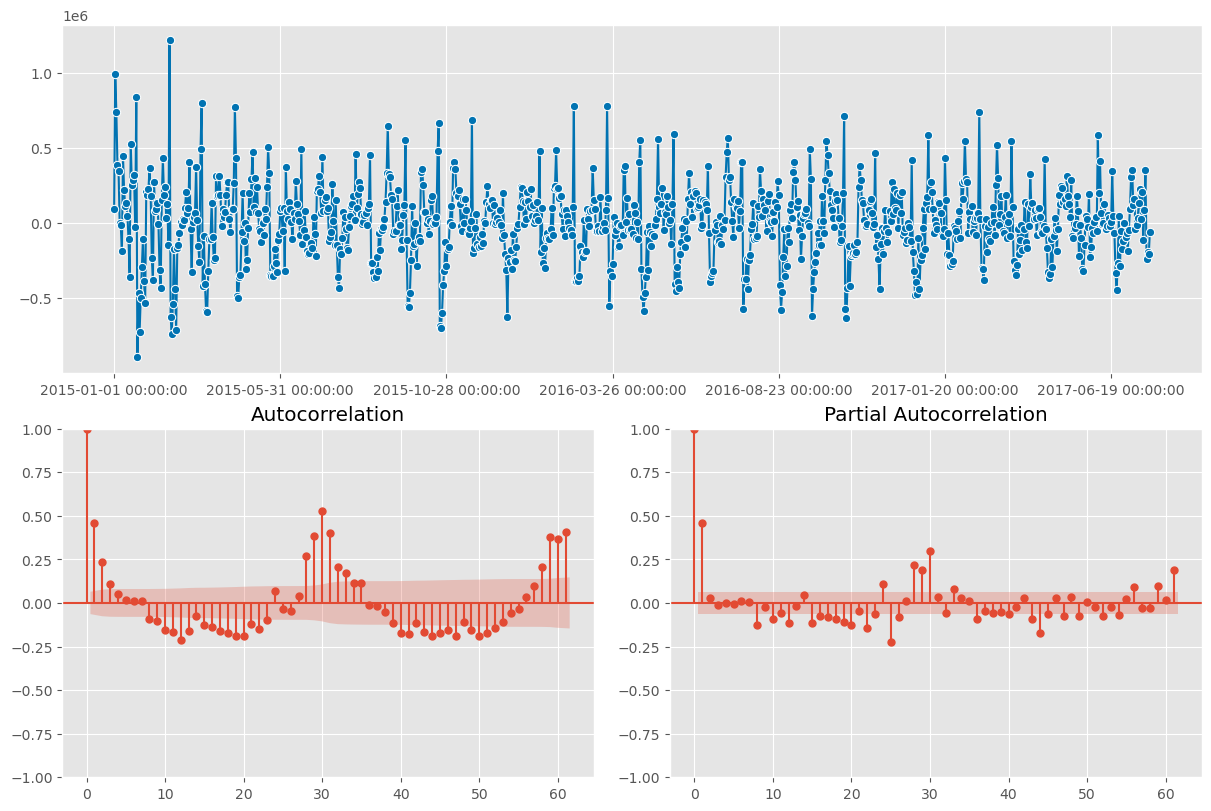

In [471]:
e_X_train_copy = e_X_train.copy()
y_hat_train = y_train.target - e_train.target
err_train_pred = model.predict(e_X_train_copy)
e_cleaned_ets = y_train.target - y_hat_train- err_train_pred
plot_correlations(e_cleaned_ets, 61);

In [472]:
n_lags = 30
n_obs = len(e_cleaned_ets)
denominators = n_obs - np.arange(1, n_lags+1)

autocorrelations = acf(e_cleaned_ets, nlags=n_lags)[1:]
ljung_box_statistics = n_obs * (n_obs +2) * ((autocorrelations**2 / denominators)).sum()
ljung_box_statistics
ljung_box_pval = 1 - chi2.cdf(ljung_box_statistics, df=n_lags)

f"Ljung-Box test. Statistics: {ljung_box_statistics}, p-value: {ljung_box_pval}" #гипотеза также отклоняется, есть серийная а/к

'Ljung-Box test. Statistics: 1050.3232572839136, p-value: 0.0'

#### Сравнение моделей

##### Визуальный анализ (0.2 балла)

Визуализируйте прогнозы STL, ETS и тестовые значения на графике. Добавьте небольшой отрезок тренировочных данных, так получится более приятный график. Сравните метрики прогнозов. Какая из двух моделей получилась лучше? Как думаете, почему? 

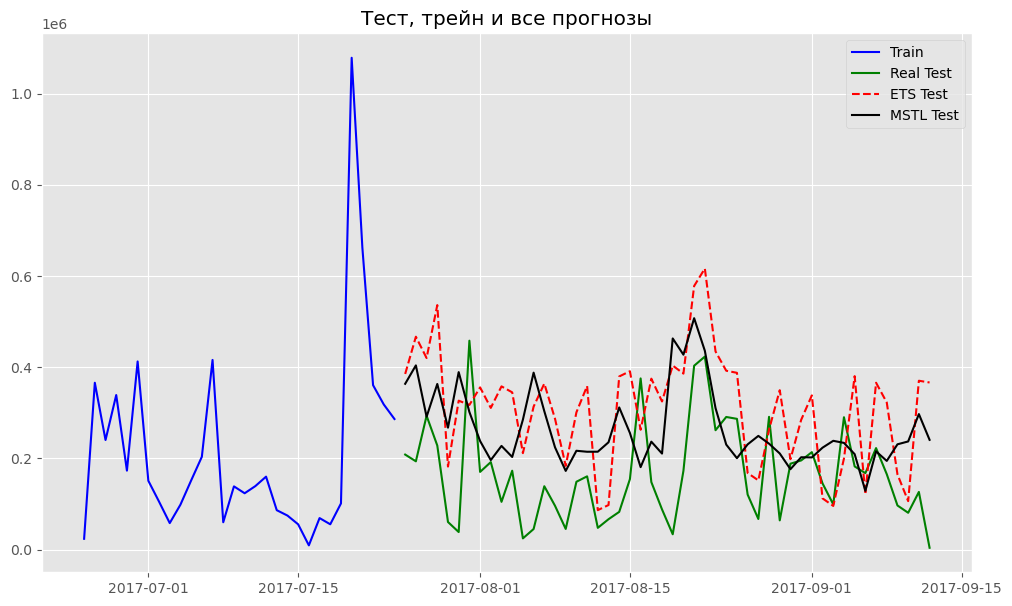

In [478]:
y_train_last = y_train.iloc[-30:]
plt.figure(figsize=(12, 7))
plt.plot(y_train_last.index, y_train_last, label='Train', color='blue')
plt.plot(y_test.index, y_test, label='Real Test ', color='green')
plt.plot(res_test_ets.index, res_test_ets, label='ETS Test', linestyle='--', color='red')
plt.plot(res_test_series_mstl.index, res_test_mstl, label='MSTL Test', color='black')
plt.legend()
plt.title('Тест, трейн и все прогнозы')
plt.show();

Обе модели имеют тенденцию завышать истинный результат на большей части прогноза. МСТЛ оказалась лучше, так как она учитывает несколько сезонностей сразу. А также она более устойчива к выбросам (плюс она разделяет прямо на компоненты ряд, что круто).

##### Сравнение  моделей (0.65 балла)

(0.2 балла) Возьмите бенчмарк в виде сезонной наивной модели, подобрав период сезонности. Постройте прогноз такой модели на тест и подсчитайте MAE. Преодолела ли хотя бы одна модель этот бенчмарк?

In [498]:
y_train = y_train.asfreq('D')  
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=31)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mean_absolute_error(y_pred, y_test) #если выбирать месячную сезонность, то ни одна модель не преодолела, если недельную - то да, обе модели лучше

117116.0

(0.15 балла за каждый корректно проведённый тест)

Проведите односторонний тест Диболда-Мариано для всех трёх возможных пар моделей. STL против ETS, STL против сезонной наивной, ETS против сезонной наивной. Нулевую гипотезу выберите самостоятельно, но тест должен быть односторонним. Готовую функцию с семинара используйте только для расчёта статистики, p-value подсчитайте для ваших гипотез самостоятельно. Проинтерпретируйте результаты всех трёх тестов. 

In [499]:
from dieboldmariano import dm_test

ets_mstl = dm_test(y_test.target.to_list(), res_test_ets, res_test_mstl, one_sided=True)[0]
ets_naive = dm_test(y_test.target.to_list(), res_test_ets, y_pred.target, one_sided=True)[0]
mstl_naive = dm_test(y_test.target.to_list(), res_test_mstl, y_pred.target, one_sided=True)[0]
print(f'Сравнение mstl и ets: {ets_mstl}')
print(f'Сравнение ets и naive: {ets_naive}')
print(f'Сравнение mstl и naive: {mstl_naive}')


Сравнение mstl и ets: 2.3295079986257
Сравнение ets и naive: 0.019729718694168844
Сравнение mstl и naive: -0.5816416093967584


In [502]:
from scipy.stats import norm
p_value_mstl_ets = 1 - norm.cdf(ets_mstl)
p_value_mstl_naive = 1 - norm.cdf(mstl_naive)
p_value_ets_naive = 1 - norm.cdf(ets_naive)

print("p-value для теста ETS против MSTL:", p_value_mstl_ets)
print("p-value для теста MSTL против наивной:", p_value_mstl_naive)
print("p-value для теста ETS против наивной:", p_value_ets_naive)

p-value для теста ETS против MSTL: 0.009916084881101406
p-value для теста MSTL против наивной: 0.7195959451894032
p-value для теста ETS против наивной: 0.49212949165048936


ETS против MSTL. Н0: модель ETS прогнозирует лучше, чем MSTL - отвергается на уровне значимости 0.05, так как p-value < 0.05. Это означает, что есть статистически значимые различия между прогностической способностью моделей STL и ETS.

MSTL против наивной. H0: наивная модель прогнозирует лучше, чем MSTL, не отвергается на уровне значимости 0.05, так как p-value > 0.05. В данном случае нет статистически значимых различий между моделями MSTL и сезонной наивной.

ETS против наивной. H0: наивная модель прогнозирует лучше, чем ETS, также не отвергается на уровне значимости 0.05, так как p-value > 0.05. Значит, нет статистически значимых различий в прогностической способности между моделями ETS и наивной.

##### Что бы вы сделали, будь у вас неприлично много денег? (0.05 балла)

P.S. Ваш семинарист хотел бы слетать в космос. 

все детство мечтала полететь в космос и связать жизнь с этим, каким образом я экономистом оказалась я не понимаю

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7 **я заполнила**